In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict
from collections import OrderedDict
from collections import Counter
import operator
from scipy import spatial 
import scipy.stats
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# reading in data

# geographical reference table
fips_df = pd.read_csv('project_data/FIPS_dim.csv')

# agricultural survey data
agg_df = pd.read_csv('cleaned_data/cleaned_nass_data.csv')
agg_df = agg_df.rename(columns={'FIPS': 'fips_code'})

# bird observation data
observation_df = pd.read_csv('cleaned_data/cleaned_observation_data.csv')

<h3> Question 1: </h3>
<b>Are certain species observed more frequently in regions with dense areas of pastureland, cropland, or irrigated land? If so, which species?</b>

First, the observation counts for each species will be aggregated by FIPS code. Importantly, there is not a temporal component to this dataset since the date is not included in the observation table. This is a limitation in the design of the dataset and if date were present, it would be used to aggregate as well.

The aggregated observation dataset, containing the species common name, fips code, and summed observation count, will be merged with the agricultural survey dataset. The join will be done on the fips_code, and the following fields will be added: irrigated_land_in_farms, pastureland_in_farms, and cropland_in_land_area. These are the fields which will be analyzed for correlations against the observation counts for each species. During the preliminary exploratory data analysis stage, these three fields exhibited interesting trends in the heatmap visualizations which should be investigated further and quantifed.

A major problem is that the models are inaccurate likely due to an intrinsic bias in the data caused by each species natural ranges. For example, some species simply only occur in certain regions of the US, so even if an area has the correct environment or habitat, the species will not occur there just because it is not in its normal range. To adjust for this, I will perform a filter on the data before it is modeled to only include the normal species ranges. To do this, only counties with a sum observation count of >50 for a species will be included. This won't account for 'vagrant' birds, which are birds that travel outside of their normal ranges by chance. They essentially are 'lost'. To account for these, a filter of max count > 1 will be applied since the likelihood of two concurrent vagrants is small.To execute correlations, default dicts will be constructed for each species containing dictionaries of the fields of interest along with a fips code. A function will be created to execute the pearson's correlation. Correlations will be visualized using a barplot on the sorted data for each variable.

Finally, linear regression will be used to drill down into the trends for species and variables which display the most interesting correlations from the correlation analyses. Scikit learn will be used for the modeling and the visualizations will be executed again using matplotlib. From the list of Pearson correlations, species and agricultural survey fields with values > 0.1 will be fed into the regression models for fitting and visualization for further analysis.

In [3]:
observation_aggregated = observation_df.groupby(['common_name', 'fips_code'], as_index=False)['observation_count'].sum()
obs_agg_merged = pd.merge(observation_aggregated, agg_df, on='fips_code')
obs_agg_merged['fips_code'] = obs_agg_merged['fips_code'].astype(str)
obs_agg_features_merged = obs_agg_merged[['common_name', 'fips_code', 'observation_count',
                                'irrigated_land_in_farms', 'cropland_in_land_area', 'pastureland_in_farms', 'land_in_farms'
                                ]]

obs_agg_features_merged.head()

,common_name,fips_code,observation_count,irrigated_land_in_farms,cropland_in_land_area,pastureland_in_farms,land_in_farms
0,American Pipit,1001,3.0,1.25,9.7,25.45,29.8
1,Eastern Meadowlark,1001,16.0,1.25,9.7,25.45,29.8
2,House Sparrow,1001,27.0,1.25,9.7,25.45,29.8
3,Killdeer,1001,60.0,1.25,9.7,25.45,29.8
4,Northern Bobwhite,1001,11.0,1.25,9.7,25.45,29.8


In [4]:
obs_agg_full = pd.merge(observation_df, agg_df, on='fips_code')
obs_agg_full = obs_agg_full.drop(columns=['Unnamed: 0_x', 'observation_id', 'sampling_event_id',
                                         'common_name_code', 'Unnamed: 0_y'])
        
obs_agg_full.head()

,common_name,fips_code,observation_count,land_in_farms,irrigated_land_in_farms,cropland_in_land_area,harvested_cropland_in_farms,pastureland_in_farms,farmland_in_convservation_program,cropland_and_pastureland_treated_with_animal_manure,cropland_treated_to_control_insects,cropland_treated_to_control_nematodes,cropland_treated_to_control_weeds,cropland_treated_to_control_growth,cropland_treated_to_control_disease
0,Northern Bobwhite,1001,1.0,29.8,1.25,9.7,24.34,25.45,1.17,10.11,27.88,0.18,58.36,23.9,0.9
1,Northern Bobwhite,1001,3.0,29.8,1.25,9.7,24.34,25.45,1.17,10.11,27.88,0.18,58.36,23.9,0.9
2,Northern Bobwhite,1001,2.0,29.8,1.25,9.7,24.34,25.45,1.17,10.11,27.88,0.18,58.36,23.9,0.9
3,Northern Bobwhite,1001,1.0,29.8,1.25,9.7,24.34,25.45,1.17,10.11,27.88,0.18,58.36,23.9,0.9
4,Northern Bobwhite,1001,1.0,29.8,1.25,9.7,24.34,25.45,1.17,10.11,27.88,0.18,58.36,23.9,0.9


In [5]:
# using a dictionary comprehension to convert to a nested dictionary

def df_to_nest (df):
    
    species_data = defaultdict(list)

    for index, row in df.iterrows():
        data = {'fips': row['fips_code'], 
                'observation_count': row['observation_count'],
                'pastureland_in_farms': row['pastureland_in_farms'],
                'irrigated_land_in_farms': row['irrigated_land_in_farms'],
                'cropland_in_land_area': row['cropland_in_land_area'],
               'land_in_farms': row['land_in_farms']}
        species_data[row['common_name']].append(data)
        
    return species_data
     
obs_agg_features_merged_dict = df_to_nest(obs_agg_features_merged)

In [6]:
# function to calculate correlations for a species using observation count and a given field
def obs_agg_correlation(species_lod, field):
    observation_counts = [d['observation_count'] for d in species_lod]
    second_field = [d[field] for d in species_lod]
    corr = scipy.stats.pearsonr(observation_counts, second_field)
    corr = corr[0].round(2)
    return corr
    
list_of_agg_fields = ['pastureland_in_farms', 'irrigated_land_in_farms', 'cropland_in_land_area', 'land_in_farms']

correlations = defaultdict(list)
for k, v in obs_agg_features_merged_dict.items():
    for field in list_of_agg_fields:
        correlations[k].append({field: obs_agg_correlation(v, field)})
        
interesting_correlations_f = []
for species, correlation in correlations.items():
    for c in correlation:
        for field, v in c.items():
            if abs(v) > 0.05:
                interesting_correlations_f.append((species, field))

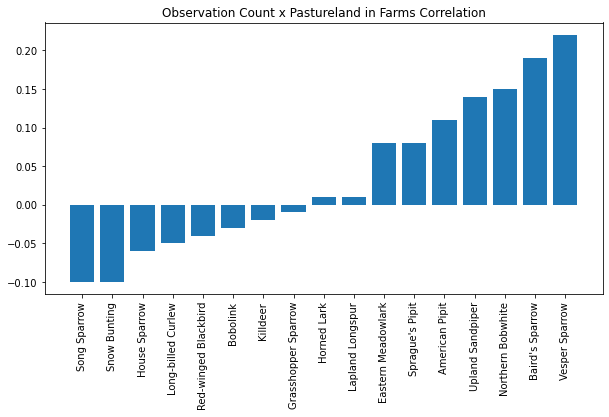

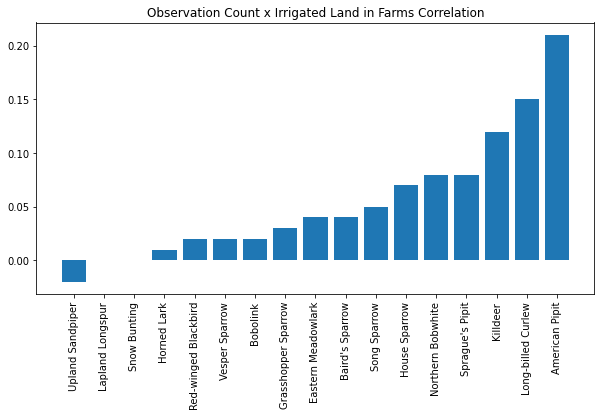

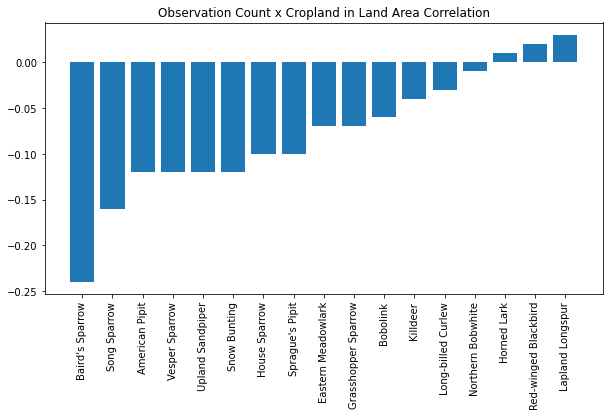

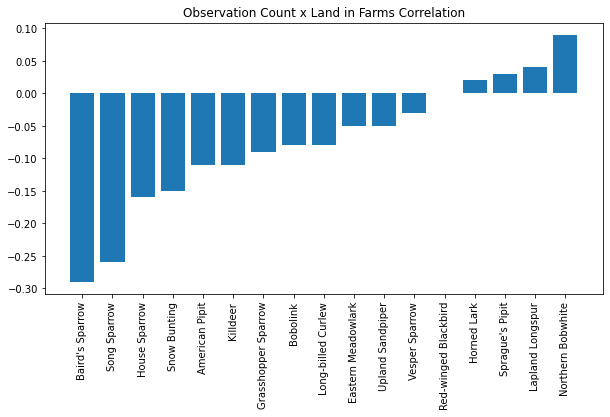

In [7]:
# visualizing correlations for each variable pair
def visualize_correlations(dct, field_label):
    fig = plt.figure(figsize = (10, 5))
    
    dct = dict(sorted(dct.items(), key=lambda i: i[1]))
    
    plt.bar(*zip(*dct.items()))
    
    title_str = 'Observation Count x ' + field_label + ' Correlation'
    plt.title(title_str)
    plt.xticks(rotation = 90)
    plt.show()
    
    
pastureland_in_farms = {}
irrigated_land_in_farms = {}
cropland_in_land_area = {}
land_in_farms = {}

for species, correlation in correlations.items():
    pastureland_in_farms[species] = correlation[0]['pastureland_in_farms']
    irrigated_land_in_farms[species] = correlation[1]['irrigated_land_in_farms']
    cropland_in_land_area[species] = correlation[2]['cropland_in_land_area']
    land_in_farms[species] = correlation[3]['land_in_farms']
    
visualize_correlations(pastureland_in_farms, 'Pastureland in Farms')
visualize_correlations(irrigated_land_in_farms, 'Irrigated Land in Farms')
visualize_correlations(cropland_in_land_area, 'Cropland in Land Area')
visualize_correlations(land_in_farms, 'Land in Farms')

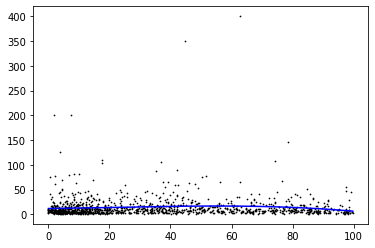

American Pipit ,  pastureland_in_farms OLS, r2: 0.009275007262144142
(1226, 3)


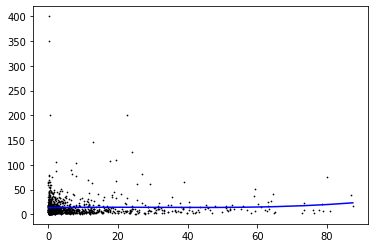

American Pipit ,  irrigated_land_in_farms OLS, r2: 0.00097906522927238
(1226, 3)


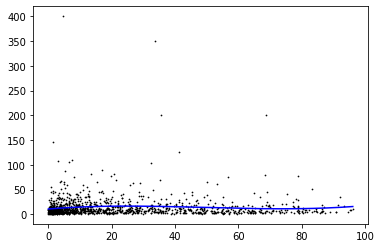

American Pipit ,  cropland_in_land_area OLS, r2: 0.007347755802549982
(1226, 3)


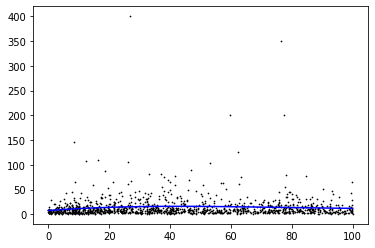

American Pipit ,  land_in_farms OLS, r2: 0.009629949774964452
(1221, 3)


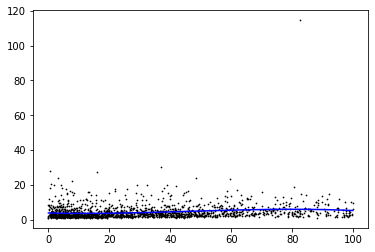

Eastern Meadowlark ,  pastureland_in_farms OLS, r2: 0.0330163354541525
(1760, 3)


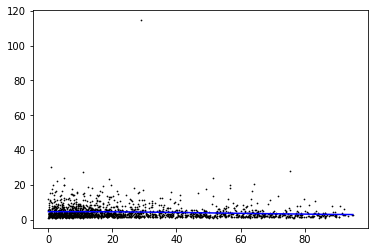

Eastern Meadowlark ,  cropland_in_land_area OLS, r2: 0.01153063145369404
(1760, 3)


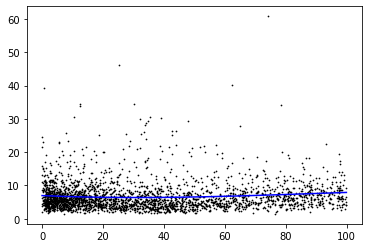

House Sparrow ,  pastureland_in_farms OLS, r2: 0.006871250644255311
(2663, 3)


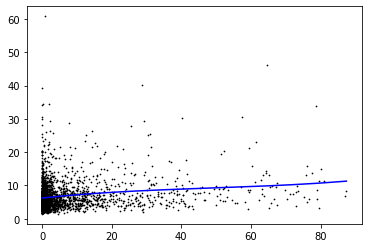

House Sparrow ,  irrigated_land_in_farms OLS, r2: 0.03747631904142801
(2663, 3)


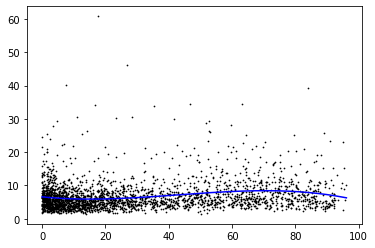

House Sparrow ,  cropland_in_land_area OLS, r2: 0.03897594576713648
(2663, 3)


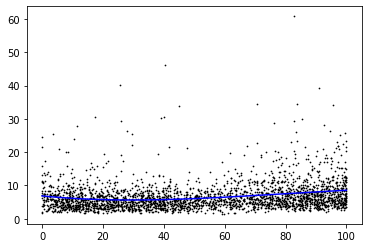

House Sparrow ,  land_in_farms OLS, r2: 0.05052982182870658
(2643, 3)


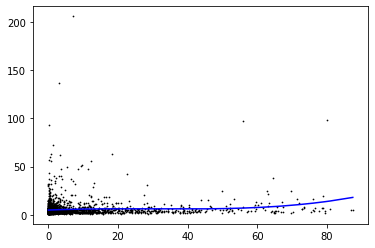

Killdeer ,  irrigated_land_in_farms OLS, r2: 0.011993641760973839
(2627, 3)


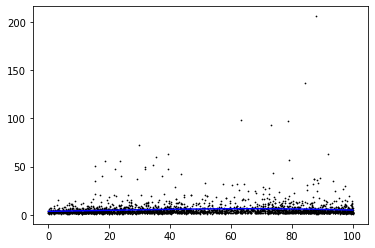

Killdeer ,  land_in_farms OLS, r2: 0.008779679784628014
(2612, 3)


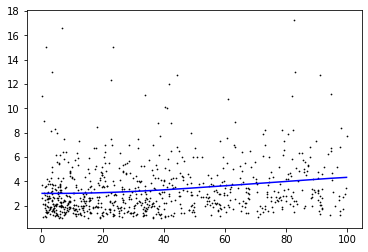

Northern Bobwhite ,  pastureland_in_farms OLS, r2: 0.03255651840408935
(787, 3)


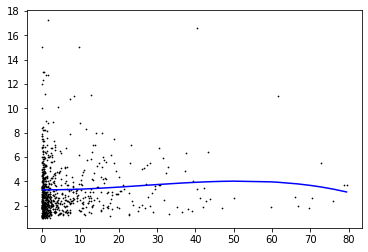

Northern Bobwhite ,  irrigated_land_in_farms OLS, r2: 0.0033664410079398133
(787, 3)


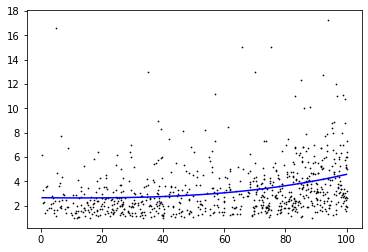

Northern Bobwhite ,  land_in_farms OLS, r2: 0.08815037008172533
(775, 3)


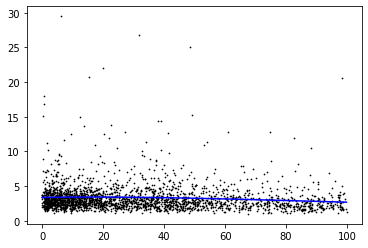

Song Sparrow ,  pastureland_in_farms OLS, r2: 0.008757181236268563
(2412, 3)


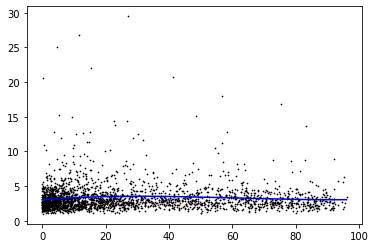

Song Sparrow ,  cropland_in_land_area OLS, r2: 0.007042509306360634
(2412, 3)


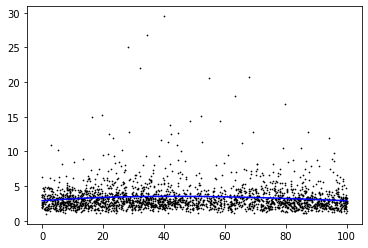

Song Sparrow ,  land_in_farms OLS, r2: 0.009717327000474452
(2401, 3)


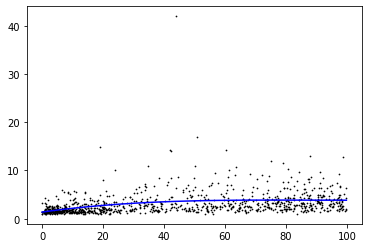

Vesper Sparrow ,  pastureland_in_farms OLS, r2: 0.13059822814147248
(988, 3)


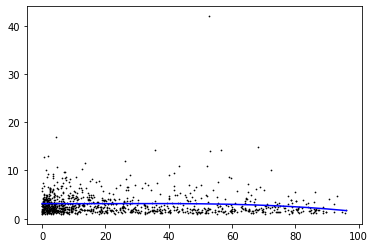

Vesper Sparrow ,  cropland_in_land_area OLS, r2: 0.008490780356456007
(988, 3)


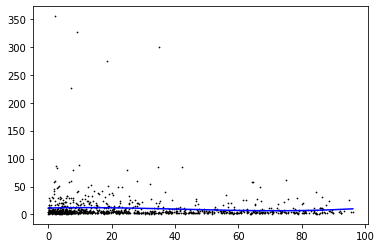

Bobolink ,  cropland_in_land_area OLS, r2: 0.007230375245793508
(971, 3)


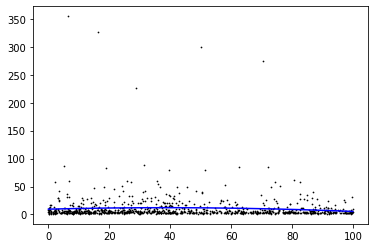

Bobolink ,  land_in_farms OLS, r2: 0.005022184602908486
(968, 3)


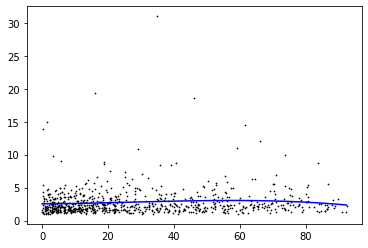

Grasshopper Sparrow ,  cropland_in_land_area OLS, r2: 0.007371022101380742
(776, 3)


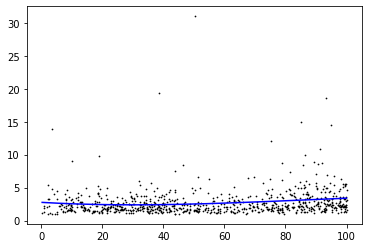

Grasshopper Sparrow ,  land_in_farms OLS, r2: 0.026813145472003308
(770, 3)


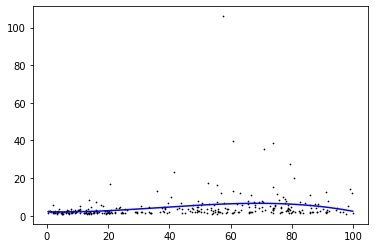

Upland Sandpiper ,  pastureland_in_farms OLS, r2: 0.0585084173279693
(320, 3)


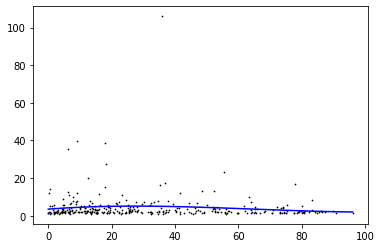

Upland Sandpiper ,  cropland_in_land_area OLS, r2: 0.011587760305606709
(320, 3)


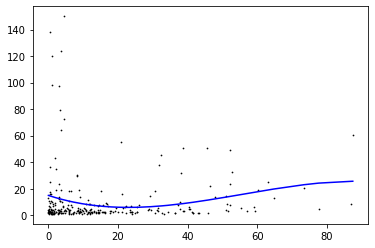

Long-billed Curlew ,  irrigated_land_in_farms OLS, r2: 0.030213977713264062
(260, 3)


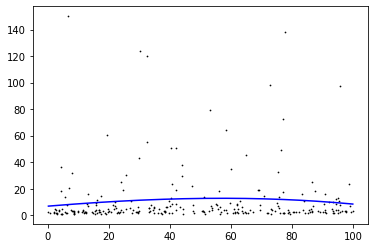

Long-billed Curlew ,  land_in_farms OLS, r2: 0.006345736832045645
(259, 3)


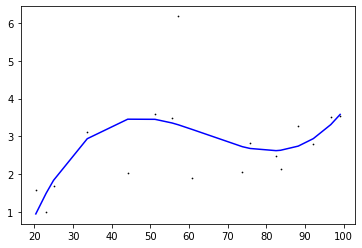

Baird's Sparrow ,  pastureland_in_farms OLS, r2: 0.3839973076921481
(17, 3)


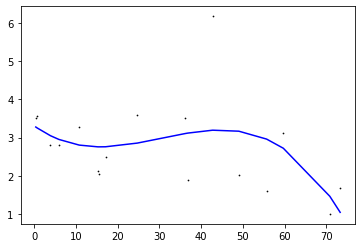

Baird's Sparrow ,  cropland_in_land_area OLS, r2: 0.26406522778808605
(17, 3)


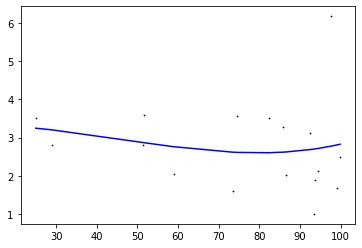

Baird's Sparrow ,  land_in_farms OLS, r2: 0.025704793395989523
(17, 3)


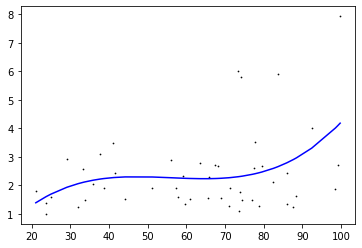

Sprague's Pipit ,  pastureland_in_farms OLS, r2: 0.14899388607034614
(49, 3)


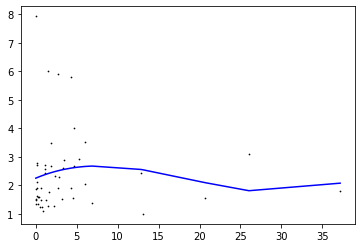

Sprague's Pipit ,  irrigated_land_in_farms OLS, r2: 0.015429502484410218
(49, 3)


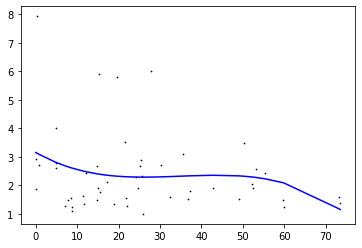

Sprague's Pipit ,  cropland_in_land_area OLS, r2: 0.06745841891589377
(49, 3)


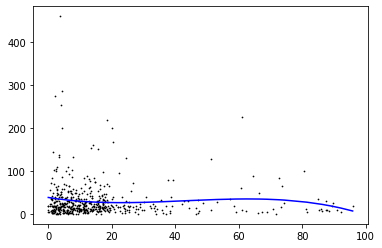

Snow Bunting ,  pastureland_in_farms OLS, r2: 0.009158365304341554
(522, 3)


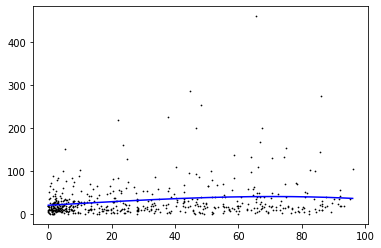

Snow Bunting ,  cropland_in_land_area OLS, r2: 0.03371061994615854
(522, 3)


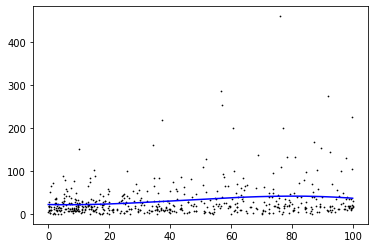

Snow Bunting ,  land_in_farms OLS, r2: 0.035787718000137025
(519, 3)


In [8]:
def linear_regr(x, y, species, field, degree):

    x = x[:, np.newaxis]
    y = y[:, np.newaxis]

    p = PolynomialFeatures(degree=degree)
    x_poly = p.fit_transform(x)

    regr = LinearRegression()
    regr.fit(x_poly, y)
    y_pred = regr.predict(x_poly)
    

    r2 = r2_score(y,y_pred)

    plt.scatter(x, y, s=0.5, color='k')
    sort_axis = operator.itemgetter(0)
    to_plot = sorted(zip(x,y_pred), key=sort_axis)
    x, y_pred = zip(*to_plot)
    plt.plot(x, y_pred, color='b')
    plt.show()
    
    print(species, ', ', field, 'OLS, r2:', r2)
    

# iterating over species and values
for species, field in interesting_correlations_f:
    df = obs_agg_full[obs_agg_full['common_name'] == species]
    df = df[df['observation_count'] > 0]
    df = df[df[field] <= 100]
    
    sum_by_county = df.groupby('fips_code')['observation_count'].sum() # getting sum obs county by county
    sum_by_county = sum_by_county[(sum_by_county > 10)]
    
    counties_to_filter_sum = list(sum_by_county.index)

    df = df[df['fips_code'].isin(counties_to_filter_sum)]
    df = df.groupby('fips_code')['observation_count'].mean()
    
    df = pd.merge(df, agg_df, on='fips_code')
    df = df[['fips_code', 'observation_count', field]]
    
    obs = np.array(df['observation_count'])
    f2 = np.array(df[field])
    
    linear_regr(f2, obs, species, field, 3)
    print(df.shape)

<h3> Question 1 Results: </h3>

<b> Is there a correlation between obesrvation count for each species and the percentage of farmland which is comprised of pastureland? </b> 

Based on the pearson correlation analysis, there are indeed some species which are observed in higher quantities in agricultural areas comprised of pastureland. The correlation coefficient for Vesper Sparrow, Baird's Sparrow, Nothern Bobwhite, and Upland Sandpiper are 0.22, 0.19, 0.15, and 0.14 respectively. It also worth pointing out that some species are less often seen in agricultural areas associated with pastureland, such as Song Sparrow and Snow Bunting.

According to the Cornell Lab of Ornithology, Vesper Sparrow populations declined more than 30% between 1970 and 2014 with root cause likely being grassland habitat loss, increased mowing, and earlier harvesting. This correlation analysis, in conjunction with the cropland in land area correlation, that pastureland is highly preferred as habitat over cropland for Vesper Sparrow.

<b>Is there a correlation between obesrvation count for each species and the percentage of farmland which is comprised of irrigated land?</b>

In this case, the pearson correlation points to American Pipit and Long-billed Curlew observation counts having the strongest correlation in this type of environment, with coefficients of 0.21 and 0.15 respectively.

Irrigated land is defined as areas where water is supplied to an agricultural environment as opposed to relying solely on rain. Typically, water is provided by spraying, flooding, or diverting natural sources. Kildeer and Long-billed Curlew are shorebirds that winter in estuaries, tidal mudflats, and estuaries, but rely on agricultural areas in the summer. Thus, it is logical that their observation counts would correlate with irrigated land percentages. According to the Cornell Lab of Ornithology, the Long-billed Curlew populations have declined significantly since the 1900s due to loss of grassland habitat to agriculture. It has also been proposed that pestide use has impacted their food supply (grasshoppers). This will be assessed in a later section of this analyses. Regardless, given the above correlation analysis, it is possible that the agricultural practice of irrigation has an impact on the geographical population densities of the Long-billed Curlew in particular.

<b>Is there a correlation between obesrvation count for each species and the percentage of land which exists as cropland?</b>

Most species have a negative correlation with observation count vs. land in cropland, but one species with a particularly strong negative correlations is the Baird's Sparrow. Per the Cornell Lab of Ornithology, this species was once one of the most common birds to reside in the tallgrass prairie of the Great Plains, but now has declined in population more than 65% since 1998 due to habitat loss to agriculture. This analysis reinforces the importance of conserving native grasslands and preventing consersion into cropland. Importantly, the agricultural land used for prairie appears to be a suitable habitat for Baird's Sparrow based on the first correlation analysis. <b>A potential recommendation to conservationists and agricultural entities in the Great Plains: leverage pastureland in regions where Baird's sparrow breeding populations have been reported and do not replace native grasslands with agricultural cropland if posible. </b>

<b> Is there a correlation between observation count for each species and percentage of land in farms? </b>

Baird's Sparrow, Song Sparrow, and House Sparrow observation counts have a moderate negative correlation with the percentage of land in farms, while Northern Bobwhite has a weakly positive correlation with land in farms.

<b> Modeling Discussion: </b>

An attempt was made to leverage the sci-kit learn linear regression model to further assess and visualize the validity of the relationships between each species observation count and the each agricultural field. To ensure best accuracy, the data aggregated by county was used. The models only loosely confirmed the correlations, with most r2 values falling below 0.10.

Initially, a linear relationship was assumed however based on plot results it was decided to attempt to leverage a polynomial fitting of degree = 3 to the models. This slightly increased model performance, but ultimately the models still were not able to perform well. The poor model performance is expected due to the large spread of observation counts. Elastic net and lasso regression were also attempted on the dataset but performance was only marginally improved.

Among the relatively notable scores:
1. House Sparrow ,  land_in_farms OLS, r2: 0.05 <br>
    a. Relationship present: house sparrow populations are slightly higher in areas with more land in farms
2. Northern Bobwhite ,  land_in_farms OLS, r2: 0.10 <br>
    a. Relationsihp present: northern bobwhite populations are slightly higher in areas with more land in farms
3. Vesper Sparrow ,  pastureland_in_farms OLS, r2: 0.13<br>
    a. Relationship present: vesper sparrow populations are higher in areas with more pastureland in farms
4. Upland Sandpiper ,  pastureland_in_farms OLS, r2: 0.06 <br>
    a. Relationship present: upland sandpiper populations are slightly higher in areas with more pastureland in farms
5. Baird's Sparrow ,  pastureland_in_farms OLS, r2: 0.39 <br>
    a. Relationship <b>possible</b>: baird's sparrow appear to have higher populations in areas with more pastureland in farms. Importantly, the sample size after filtering to omit vagrants is only 17 observations. This has an impact on the model.
6. Baird's Sparrow ,  cropland_in_land_area OLS, r2: 0.26 <br>
    a. Relationship <b>possible</b>: baird's sparrow appear to have higher populations in areas with more cropland.   Importantly, the sample size after filtering to omit vagrants is only 17 observations. This has an impact on the model.
7. Sprague's Pipit ,  cropland_in_land_area OLS, r2: 0.07 <br>
    a. Relationship <b>possible</b>: Sprague's pipit appears to have higher populations in area with more cropland. Importantly, the sample size after filtering to omit vagrants is only 49 observations. This has an impact on the model.

Sources:
https://www.allaboutbirds.org/guide/Long-billed_Curlew/overview</br>
https://www.allaboutbirds.org/guide/Bairds_Sparrow/overview<br>
https://www.allaboutbirds.org/guide/Vesper_Sparrow/lifehistory

<h3> Question 2: </h3>

<b>What are the population densities of species in regions with higher usage of chemicals or animal manure to control insects, growth, and disease? Do the populations of species appear to be affected by these variables?</b>

To execute this analysis, the same correlation function will be used but this time on the chemical treatment fields, including:
1. Cropland treated to control insects
2. Cropland treated to control nematodes
3. Cropland treated to control weeds
4. Cropland treated to control growth
5. Cropland treated to control disease

The intention is to probe the possibility that cropland treated to control various agricultural nuiscances could impact species populations in agricultural settings. For example, it has been hypothesized by Cornell Lab of Ornithology that chemical use to control insects has directly impacted long-billed curlew populations by hindering their food source, which is primarily comprised of insects during the summer months. Other species may be impacted by similar phenomena. 

Cropland and pastureland treated with animal manure will also be included in this analysis. Some opportunistic species tend to associate with farm fields treated with animal manure, such as horned lark, due to the presence of additional food sources. That hypothesis will be tested in the following analysis.

In addition to the correlation analysis, an attempt will be made to run a support vector regression model on a specific species to predict the observation count of a species using the strongest correlated variables. Linear regression will not be used in this case since the relationship was revealed to be non-linear during exploratory data analysis. From the list of Pearson correlations, species and agricultural survey fields with values > 0.1 will be fed into the regression models for fitting and visualization for further analysis.

In [9]:
obs_agg_treatments_merged = obs_agg_merged[['common_name', 'fips_code', 'observation_count',
                                'cropland_and_pastureland_treated_with_animal_manure',
                                 'cropland_treated_to_control_insects',
                                 'cropland_treated_to_control_nematodes',
                                 'cropland_treated_to_control_weeds',
                                 'cropland_treated_to_control_growth',
                                 'cropland_treated_to_control_disease'
                                ]]

obs_agg_treatments_merged.head()

,common_name,fips_code,observation_count,cropland_and_pastureland_treated_with_animal_manure,cropland_treated_to_control_insects,cropland_treated_to_control_nematodes,cropland_treated_to_control_weeds,cropland_treated_to_control_growth,cropland_treated_to_control_disease
0,American Pipit,1001,3.0,10.11,27.88,0.18,58.36,23.9,0.9
1,Eastern Meadowlark,1001,16.0,10.11,27.88,0.18,58.36,23.9,0.9
2,House Sparrow,1001,27.0,10.11,27.88,0.18,58.36,23.9,0.9
3,Killdeer,1001,60.0,10.11,27.88,0.18,58.36,23.9,0.9
4,Northern Bobwhite,1001,11.0,10.11,27.88,0.18,58.36,23.9,0.9


In [10]:
# using a dictionary comprehension to convert to a nested dictionary

def df_to_nest_treatments (df):
    
    species_data = defaultdict(list)

    for index, row in df.iterrows():
        data = {'fips': row['fips_code'], 
                'observation_count': row['observation_count'],
                'cropland_and_pastureland_treated_with_animal_manure': row['cropland_and_pastureland_treated_with_animal_manure'],
                'cropland_treated_to_control_insects': row['cropland_treated_to_control_insects'],
                'cropland_treated_to_control_nematodes': row['cropland_treated_to_control_nematodes'],
                'cropland_treated_to_control_weeds': row['cropland_treated_to_control_weeds'],
                'cropland_treated_to_control_growth': row['cropland_treated_to_control_growth'],
                'cropland_treated_to_control_disease': row['cropland_treated_to_control_disease']
               }
        species_data[row['common_name']].append(data)
        
    return species_data

obs_agg_treatments_merged_dict = df_to_nest_treatments(obs_agg_treatments_merged)

In [11]:
list_of_treatment_fields = ['cropland_and_pastureland_treated_with_animal_manure',
                                 'cropland_treated_to_control_insects',
                                 'cropland_treated_to_control_nematodes',
                                 'cropland_treated_to_control_weeds',
                                 'cropland_treated_to_control_growth',
                                 'cropland_treated_to_control_disease']

correlations = defaultdict(list)
for k, v in obs_agg_treatments_merged_dict.items():
    for field in list_of_treatment_fields:
        correlations[k].append({field: obs_agg_correlation(v, field)})
           
interesting_correlations_a = []
for species, correlation in correlations.items():
    for c in correlation:
        for field, v in c.items():
            if abs(v) > 0.05:
                interesting_correlations_a.append((species, field))

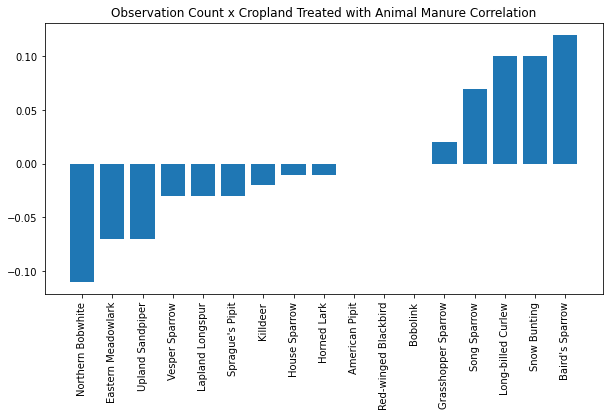

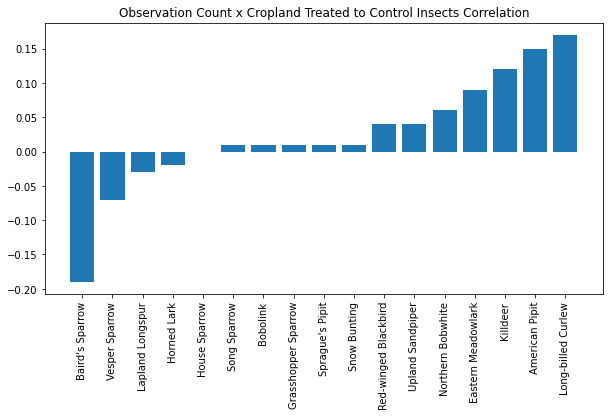

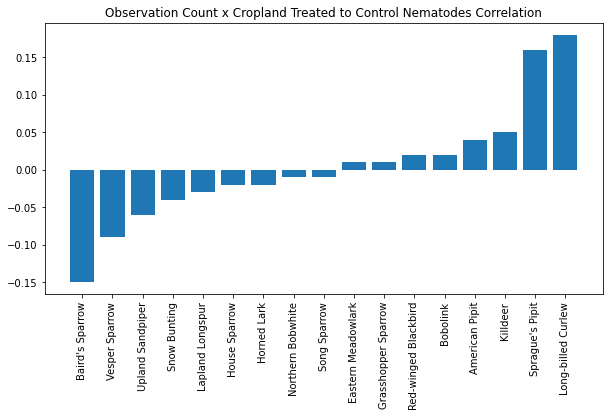

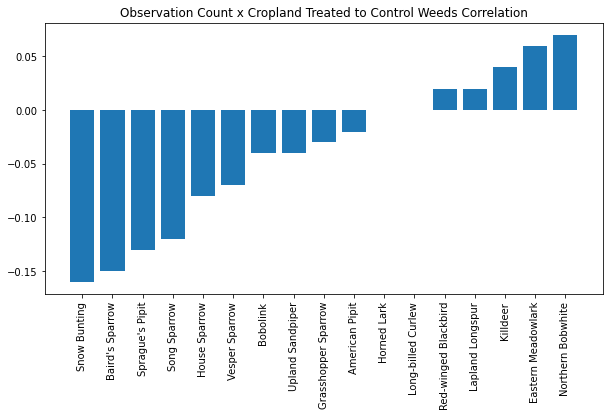

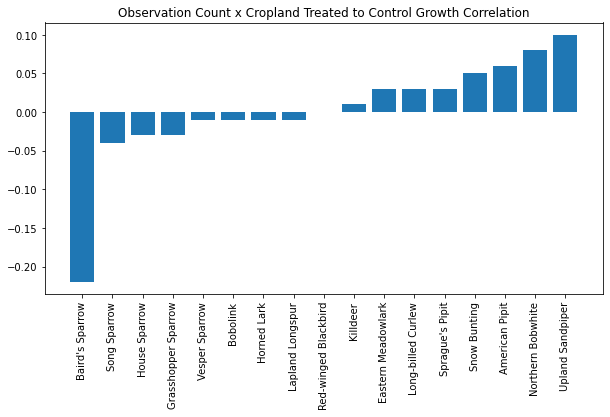

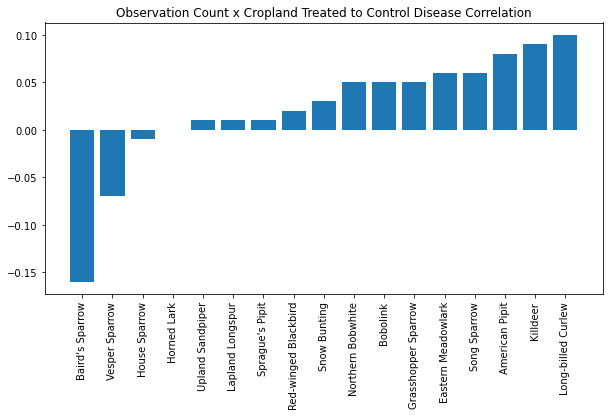

In [12]:
# visualizing correlations for each variable pair
animal_manure = {}
insects = {}
nematodes = {}
weeds = {}
growth = {}
disease = {}

for species, correlation in correlations.items():
    animal_manure[species] = correlation[0]['cropland_and_pastureland_treated_with_animal_manure']
    insects[species] = correlation[1]['cropland_treated_to_control_insects']
    nematodes[species] = correlation[2]['cropland_treated_to_control_nematodes']
    weeds[species] = correlation[3]['cropland_treated_to_control_weeds']
    growth[species] = correlation[4]['cropland_treated_to_control_growth']
    disease[species] = correlation[5]['cropland_treated_to_control_disease']
    
visualize_correlations(animal_manure, 'Cropland Treated with Animal Manure')
visualize_correlations(insects, 'Cropland Treated to Control Insects')
visualize_correlations(nematodes, 'Cropland Treated to Control Nematodes')
visualize_correlations(weeds, 'Cropland Treated to Control Weeds')
visualize_correlations(growth, 'Cropland Treated to Control Growth')
visualize_correlations(disease, 'Cropland Treated to Control Disease')

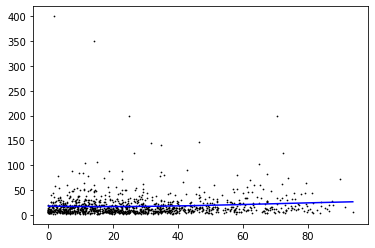

American Pipit ,  cropland_treated_to_control_insects OLS, r2: 0.006427271972798354
(1180, 3)


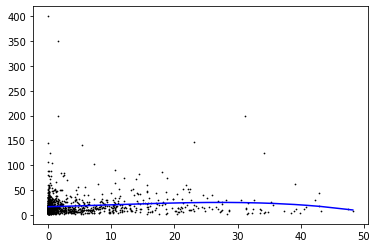

American Pipit ,  cropland_treated_to_control_growth OLS, r2: 0.010058562921228531
(1180, 3)


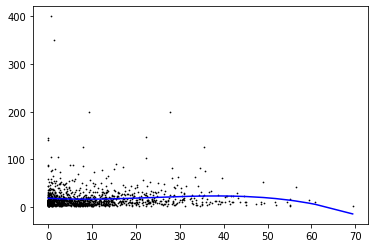

American Pipit ,  cropland_treated_to_control_disease OLS, r2: 0.007024551507298971
(1180, 3)


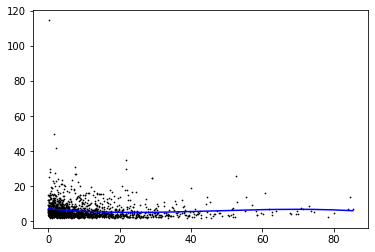

Eastern Meadowlark ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.01602869162091891
(1632, 3)


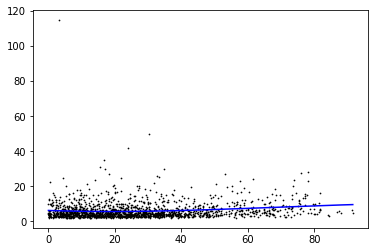

Eastern Meadowlark ,  cropland_treated_to_control_insects OLS, r2: 0.020892612406717026
(1634, 3)


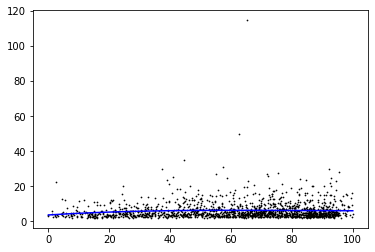

Eastern Meadowlark ,  cropland_treated_to_control_weeds OLS, r2: 0.007057249196979698
(1581, 3)


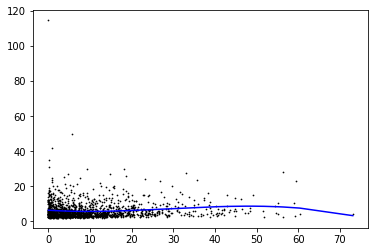

Eastern Meadowlark ,  cropland_treated_to_control_disease OLS, r2: 0.01218499028817277
(1634, 3)


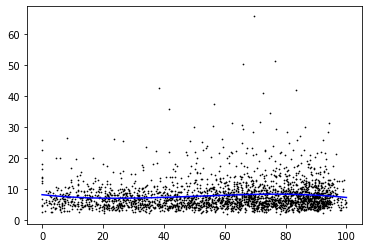

House Sparrow ,  cropland_treated_to_control_weeds OLS, r2: 0.00883772451211362
(2564, 3)


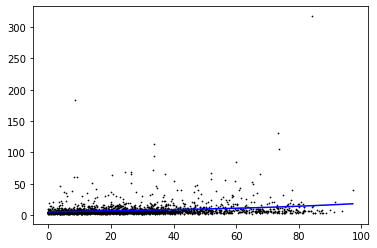

Killdeer ,  cropland_treated_to_control_insects OLS, r2: 0.03686545825122256
(2545, 3)


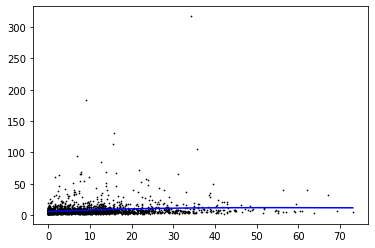

Killdeer ,  cropland_treated_to_control_disease OLS, r2: 0.027558671115826994
(2545, 3)


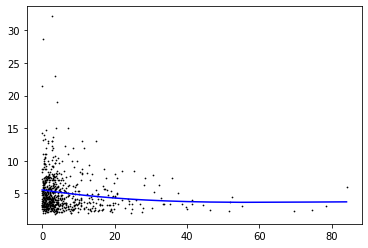

Northern Bobwhite ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.021439168320092294
(686, 3)


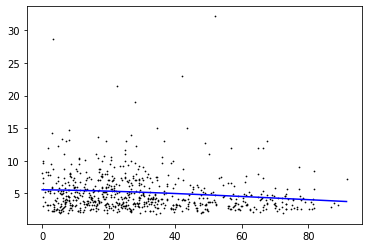

Northern Bobwhite ,  cropland_treated_to_control_insects OLS, r2: 0.01906455822404196
(686, 3)


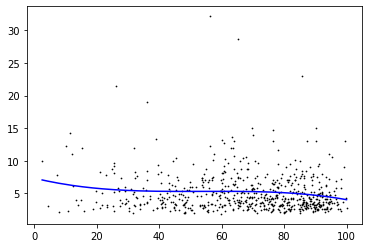

Northern Bobwhite ,  cropland_treated_to_control_weeds OLS, r2: 0.014029483920010466
(656, 3)


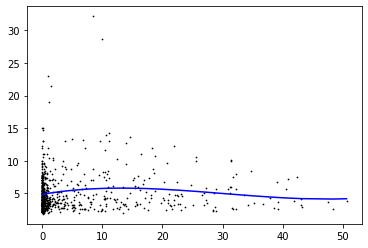

Northern Bobwhite ,  cropland_treated_to_control_growth OLS, r2: 0.014220329301971812
(686, 3)


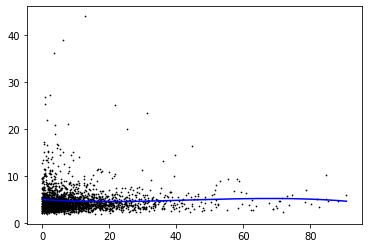

Song Sparrow ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.002905485352721282
(2311, 3)


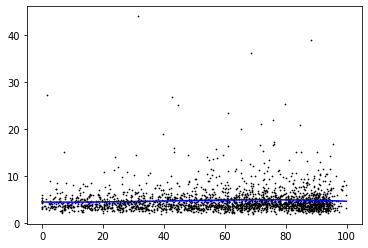

Song Sparrow ,  cropland_treated_to_control_weeds OLS, r2: 0.003837511112681158
(2269, 3)


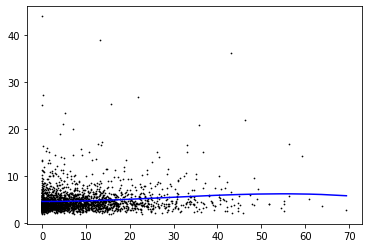

Song Sparrow ,  cropland_treated_to_control_disease OLS, r2: 0.013576151156599936
(2314, 3)


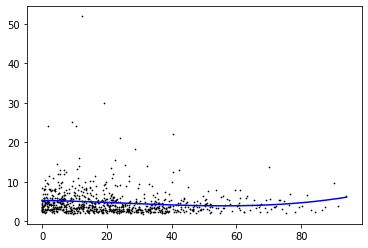

Vesper Sparrow ,  cropland_treated_to_control_insects OLS, r2: 0.016802468978937113
(826, 3)


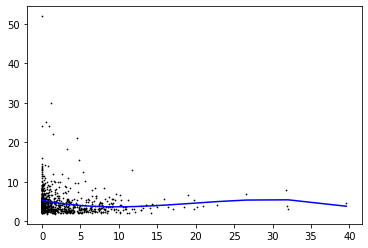

Vesper Sparrow ,  cropland_treated_to_control_nematodes OLS, r2: 0.030692092815356342
(826, 3)


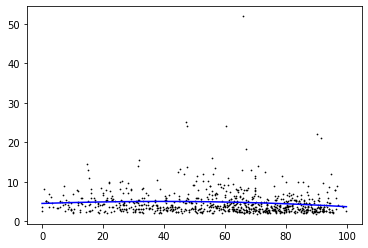

Vesper Sparrow ,  cropland_treated_to_control_weeds OLS, r2: 0.009881039525563184
(795, 3)


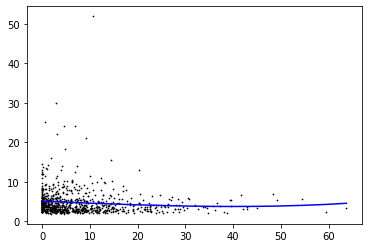

Vesper Sparrow ,  cropland_treated_to_control_disease OLS, r2: 0.011613388591365181
(826, 3)


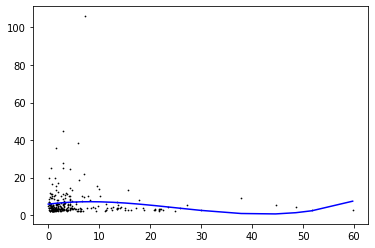

Upland Sandpiper ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.011334106481319828
(262, 3)


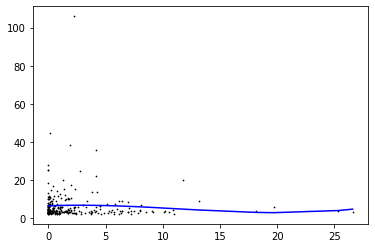

Upland Sandpiper ,  cropland_treated_to_control_nematodes OLS, r2: 0.003365756438204137
(262, 3)


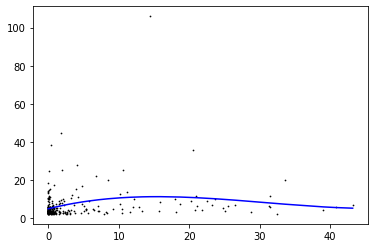

Upland Sandpiper ,  cropland_treated_to_control_growth OLS, r2: 0.057075619644016196
(262, 3)


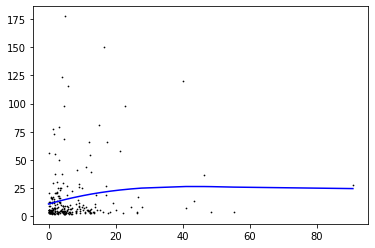

Long-billed Curlew ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.025154241998239568
(235, 3)


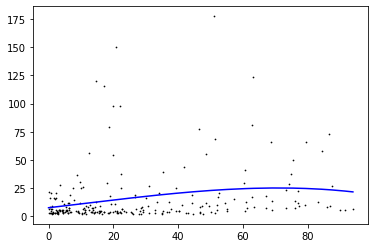

Long-billed Curlew ,  cropland_treated_to_control_insects OLS, r2: 0.056510714607159174
(235, 3)


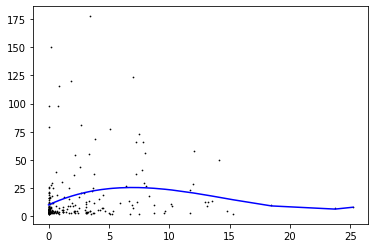

Long-billed Curlew ,  cropland_treated_to_control_nematodes OLS, r2: 0.052108773476906456
(235, 3)


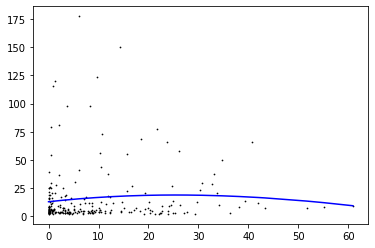

Long-billed Curlew ,  cropland_treated_to_control_disease OLS, r2: 0.007520739276003052
(235, 3)


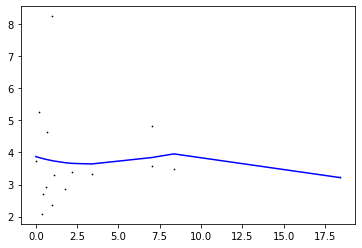

Baird's Sparrow ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.012332530841171252
(16, 3)


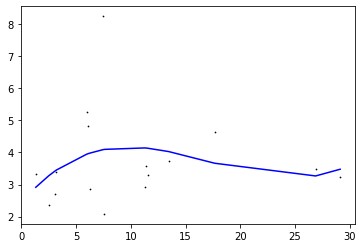

Baird's Sparrow ,  cropland_treated_to_control_insects OLS, r2: 0.07165544676878954
(16, 3)


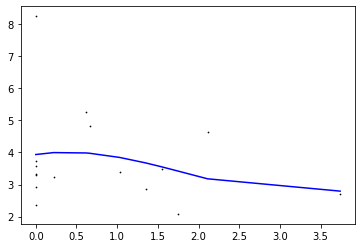

Baird's Sparrow ,  cropland_treated_to_control_nematodes OLS, r2: 0.055497778965895694
(16, 3)


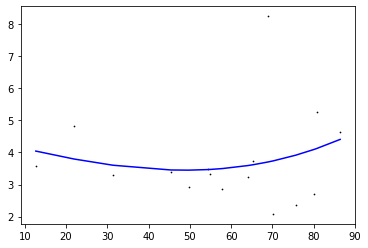

Baird's Sparrow ,  cropland_treated_to_control_weeds OLS, r2: 0.03891118954109307
(16, 3)


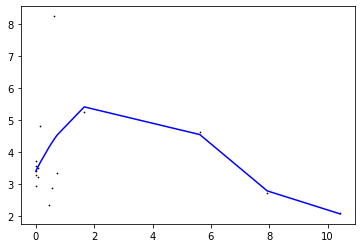

Baird's Sparrow ,  cropland_treated_to_control_growth OLS, r2: 0.2860104861556386
(16, 3)


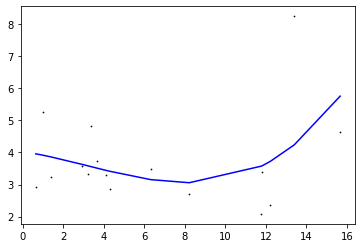

Baird's Sparrow ,  cropland_treated_to_control_disease OLS, r2: 0.17110749914408896
(16, 3)


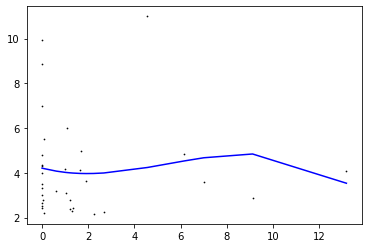

Sprague's Pipit ,  cropland_treated_to_control_nematodes OLS, r2: 0.010504414382766059
(34, 3)


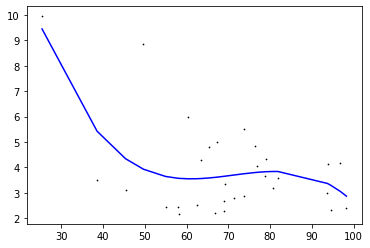

Sprague's Pipit ,  cropland_treated_to_control_weeds OLS, r2: 0.3823767861864473
(30, 3)


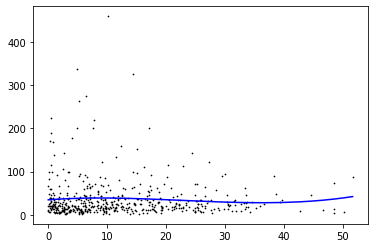

Snow Bunting ,  cropland_and_pastureland_treated_with_animal_manure OLS, r2: 0.004163558629842412
(515, 3)


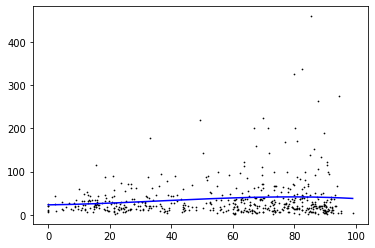

Snow Bunting ,  cropland_treated_to_control_weeds OLS, r2: 0.018053295598609798
(514, 3)


In [13]:
# iterating over species and values
for species, field in interesting_correlations_a:
    df = obs_agg_full[obs_agg_full['common_name'] == species]
    df = df[df['observation_count'] > 1]
    df = df[df[field] <= 100]
    
    sum_by_county = df.groupby('fips_code')['observation_count'].sum() # getting sum obs county by county
    sum_by_county = sum_by_county[(sum_by_county > 10)]
    
    counties_to_filter_sum = list(sum_by_county.index)

    df = df[df['fips_code'].isin(counties_to_filter_sum)]
    df = df.groupby('fips_code')['observation_count'].mean()
    
    df = pd.merge(df, agg_df, on='fips_code')
    df = df[['fips_code', 'observation_count', field]]
    
    obs = np.array(df['observation_count'])
    f2 = np.array(df[field])
    
    linear_regr(f2, obs, species, field, 3)
    print(df.shape)

In [14]:
# a major problem is that the models are inaccurate likely due to an intrinsic bias in the data caused by each species natural ranges.
# for example, some species simply only occur in certain regions of the US, so even if an area has the correct environment or habitat,
# the species will not occur there just because it is not in its normal range.
# to adjust for this, I will perform a filter on the data before it is modeled to only include the normal species ranges
# to do this, only counties with a sum observation count of >100 for a species will be included
# this won't account for 'vagrant' birds, which are birds that travel outside of their normal ranges by chance. They essentially are 'lost'.
# to account for these, a filter of max count > 1 will be applied since the likelihood of two concurrent vagrants is small.



<h3> Question 2 Results: </h3>

<b>Do the populations of species appear to have some relationship with the use of chemicals to control insects, growth, disease, and other pests?</b>

The pearson coefficient correlation results resulted in results meritting further investigation. As was discussed in question 1 analysis, it is quite important to consider that correlation does not imply causality and also that the sample size directly impacts the correlation. Some species are only seen in a limited geographic range (less data points), so those correlations may result in artifacts and exaggerated pearson coefficients and poor performance during linear regression modeling. 

With that said, there were several interesting correlations to highlight with potential scientific substance:
1. First, it is known that snow buntings, sparrows, and other songbirds feed in animal manure in the winter becaues it contains seeds. Other species, such as Long-billed Curlew, use animal manure chips for nest construction per East Side Audubon Society. The pearson correlation results appear to detect these species' preference for animal manure in farmland, as all three species have pearson correlation values of approximately 0.1, indicating a weak correlation.
2. The treatment of agricultural land with chemicals to control insects is another point of interest. Several of the species in this analysis rely on insects for food. As mentioned earlier in the discussion, Long-Billed Curlew rely heavily on grasshopper populations for food and the use of pestides has been proposed as a primary cause of the species' decline in recent years. Interestingly, the above analysis resulted in a relatively moderate correlation between Long-Billed Curlew observation counts and percentage of farmland treated with chemicals to control insects. <b>This is a very important point for further investigation (though out-of-scope for this analysis). Areas where Long-Billed Curlew have high population densities and likely breeding populations are being treated more heavily with chemicals to control insects, thus impacting their food supply and survival likelihood.</b> Along the same line, American Pipits also rely heavily on insects for their food supply. While this species is listed as least concern in terms of conservation by the Audubon Society, the low-moderate correlation with percentage of farmland treated with insecticide raises an interesting point that the species populations may be slightly more concentrated in areas with an abundance of insects in the farmland. From the opposing end, Baird's Sparrow exhibited a moderate strength negative correlation of nearly -0.2. It could be that the small sample size impacted results, so this requires further evaluation. However, the result begs the question of whether insecticide use has already impacted their populations.
3. Treatment of agricultural land with chemicals to control nematodes yielded some interesting discussion fodder as well. The strongest correlation was that of the Long-Billed Curlew. Upon researching the relationship between nematodes and the Long-Billed Curlew, I learned that nematodes are actually a common parasite of this species. <b>This is particularly interesting, as it makes sense that areas treated to control a parasite of the Long-billed Curlew would have higher populations of the species</b>. Could this be an artifact, or is there substance to this? Further analysis required.
4. Treatment of agricultural land with chemicals to control weeds resulted in some potentially obvious correlations to the seasoned birdwatcher. Weeds and shrubs are important habitat requirements for many songbirds, including sparrows and buntings. It is logical that Snow Bunting, Song Sparrow, Vesper Sparrow, House Sparrow, and Sprague's Pipit would exhibit negative correlations with this field. Many grassland birds rely on brush and weeds for cover and nesting habitat. Treating farmland with weed/brush control significantly decreases habitat for birds.

<b>Model Performance:</b>

Linear regression was executed on the data to further examine the correlations. Oridinal Least Squares was run first, with a polynomial of degree = 2, followed by elastic net, lasso regression, and ridge regression, echoing the analysis of question 1. Unfortunately, due to the extremely high heterogeneity of the observations, the models had very poor prediction scoring.While this again loosely speaks to the correlation of the two variables, it is evident that the dataset is too heterogeneic and the pattern in the data is not strong enough to be effectively modeled.

Among the notable scores:
1. Upland Sandpiper ,  cropland_treated_to_control_growth OLS, r2: 0.06<br>
    a. Relationship present: upland sandpiper observation counts are slightly higher in areas treatment to control growth
2. Long-billed Curlew ,  cropland_treated_to_control_insects OLS, r2: 0.06<br>
    a. Relationship present: long-billed curlew observation counts are slightly higher in areas treated to control insects
3. Long-billed Curlew ,  cropland_treated_to_control_nematodes OLS, r2: 0.05<br>
    a. Interesting relationship: parabolic fit with potential 'happy medium' for long-billed curlew populations in areas treated to control nematode populations.
4. Sprague's Pipit ,  cropland_treated_to_control_weeds OLS, r2: 0.38<br>
    a. While there is population for overfitting in this model, there appears to be a relationship between these two fields.
5. Baird's Sparrow ,  cropland_treated_to_control_disease OLS, r2: 0.17<br>
    a. While there is population for overfitting in this model, there appears to be a relationship between these two fields.
    
As already mentioned, it is important to emphasize that correlation != causation. There are likely other factors not present in this dataset that more accurately describe the root cause of population differences in those areas. Another key factor to keep in mind is that some species range are simply limited to their migration patterns (e.g., some species exclusively breed in the midwest or northeast US, so there is <b> intrinsic bias </b> in the sample set that cannot easily be accounted for.

Sources:
https://www.eastsideaudubon.org/corvid-crier/2019/8/26/long-billled-curlew
https://www.fs.usda.gov/Internet/FSE_DOCUMENTS/stelprdb5182037.pdf

<h3> Question 3:</h3> 

<b>Do areas with more acres enrolled in conservation programs have richer populations of grassland-dependent species? Furthermore, can we predict the result of increased land in conservation programs?</b>

There are a few components to this question:
1. What is the relationship between acres of land enrolled in conservation programs vs. observation count for each species?
2. Can a model be developed to predict how species populations might react to increased land in conservation programs?

It is important to keep in mind that 'percentage of land enrolled in agricultural land' is a composite umbrella term for the actual description of the field by the USDA: Acres Enrolled in the Conservation Reserve, Wetlands Reserve, Farmable Wetlands, or Conservation Reserve Enhancement Programs as Percent of Land in Farms Acreage. Still, this question is the core of conservation efforts, especially for more critical species like Baird's Sparrow and Sprague's Pipit with limited ranges. 

The intention of this question is to guide conservation decisions by presenting the following relationship:<br>

If land conservation were to increase X% in county Y, species population would increase/decrease by Z.

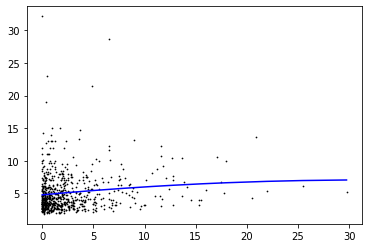

Northern Bobwhite ,  farmland_in_convservation_program OLS, r2: 0.017620686823650478
(686, 3)


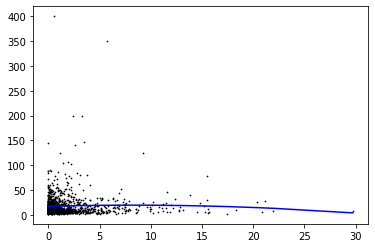

American Pipit ,  farmland_in_convservation_program OLS, r2: 0.001193398516257771
(1180, 3)


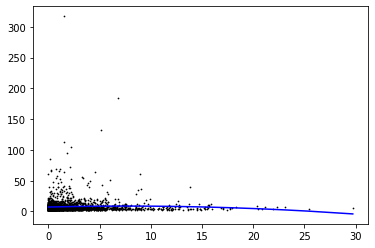

Killdeer ,  farmland_in_convservation_program OLS, r2: 0.0030295387896742687
(2545, 3)


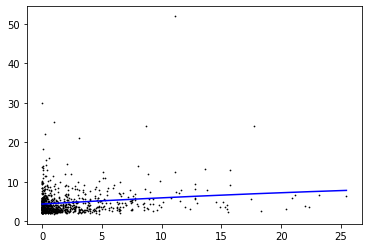

Vesper Sparrow ,  farmland_in_convservation_program OLS, r2: 0.026540522439073566
(826, 3)


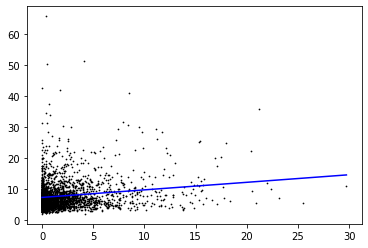

House Sparrow ,  farmland_in_convservation_program OLS, r2: 0.026639824034682458
(2634, 3)


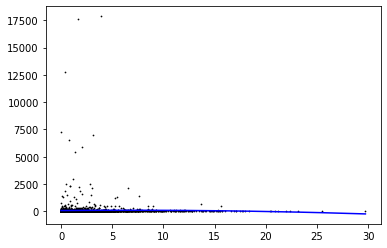

Red-winged Blackbird ,  farmland_in_convservation_program OLS, r2: 0.0004905885214456784
(2844, 3)


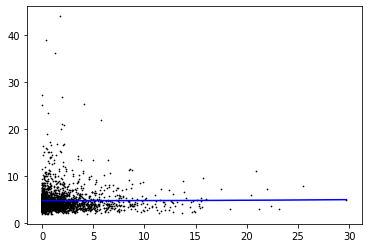

Song Sparrow ,  farmland_in_convservation_program OLS, r2: 9.414188211986918e-06
(2314, 3)


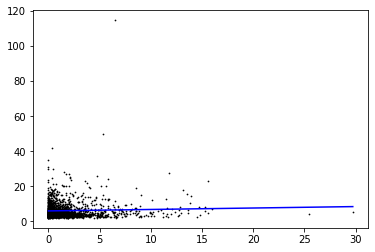

Eastern Meadowlark ,  farmland_in_convservation_program OLS, r2: 0.001813437858750433
(1634, 3)


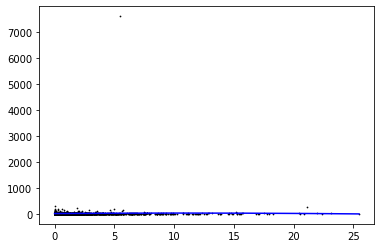

Horned Lark ,  farmland_in_convservation_program OLS, r2: 0.000675367338646371
(1598, 3)


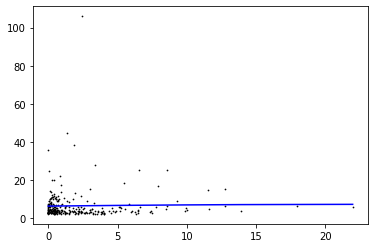

Upland Sandpiper ,  farmland_in_convservation_program OLS, r2: 0.00048185548174151105
(262, 3)


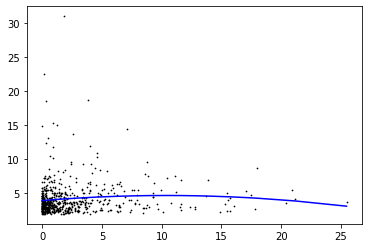

Grasshopper Sparrow ,  farmland_in_convservation_program OLS, r2: 0.008369456597713154
(628, 3)


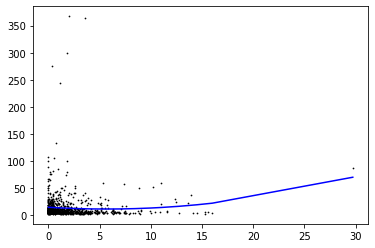

Bobolink ,  farmland_in_convservation_program OLS, r2: 0.007144169031523151
(933, 3)


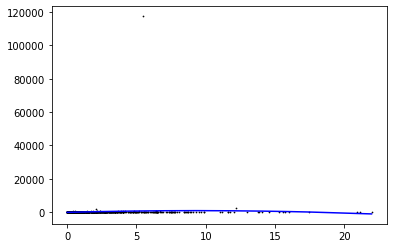

Lapland Longspur ,  farmland_in_convservation_program OLS, r2: 0.004118490509586126
(594, 3)


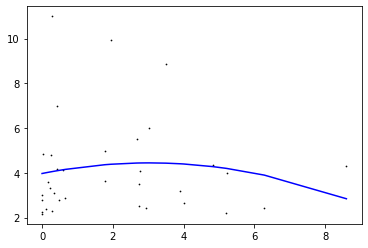

Sprague's Pipit ,  farmland_in_convservation_program OLS, r2: 0.018565683068808903
(34, 3)


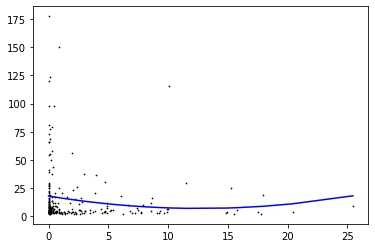

Long-billed Curlew ,  farmland_in_convservation_program OLS, r2: 0.018526960141494797
(235, 3)


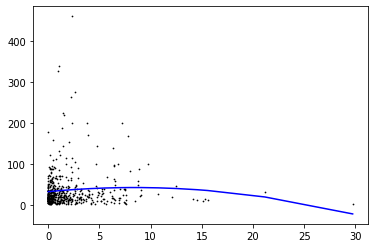

Snow Bunting ,  farmland_in_convservation_program OLS, r2: 0.007913544756378621
(515, 3)


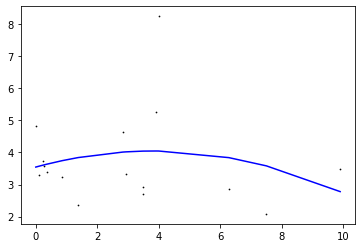

Baird's Sparrow ,  farmland_in_convservation_program OLS, r2: 0.04896496173000675
(16, 3)


In [15]:
species = list(obs_agg_full['common_name'].unique())

for specie in species:
    field = 'farmland_in_convservation_program'
    df = obs_agg_full[obs_agg_full['common_name'] == specie]
    df = df[df['observation_count'] > 1]
    df = df[df[field] <= 100]

    sum_by_county = df.groupby('fips_code')['observation_count'].sum() # getting sum obs county by county
    sum_by_county = sum_by_county[(sum_by_county > 10)]

    counties_to_filter_sum = list(sum_by_county.index)

    df = df[df['fips_code'].isin(counties_to_filter_sum)]
    df = df.groupby('fips_code')['observation_count'].mean()

    df = pd.merge(df, agg_df, on='fips_code')
    df = df[['fips_code', 'observation_count', field]]

    obs = np.array(df['observation_count'])
    f2 = np.array(df[field])

    linear_regr(f2, obs, specie, field, 2)
    print(df.shape)

<b>Question 3 Takeaway: </b> A significant issue with the dataset in this analysis is that it is sourced from a citizen science web application (eBird) that relies on individual birdwatchers to track their sightings. While in theory this is an excellent concept, it becomes an issue when working with large scale geographical datasets like the one in this analysis, spanning entire nations. The variation in the number of birdwatchers logging their sightings on eBird in different counties is an obvious bias present in the dataset. Counties with large numbers of birdwatchers will likely log higher counts of a given species, even if the ground truth is that species has higher populations in counties with lower counts of sightings due to less eBird activity.

Because of this limitation, there is little that can be done in terms of predictive modeling, especially with respect to variables like effect of farmland in conservation areas. While the scope of this project is somewhat hindered by this limitation, it is a critical learning experience in the subject area of machine learning regarding data quality and reliability. Even with ideal modeling and the correct technologies, if the data is not complete, the model will be inaccurate. 

<h3> Question 4: </h3>

<b> Do certain species tend to appear in clusters together? For example, do Baird's Sparrows populations coincide with Sprague's Pipit populations at the county level?</b>

Networks will be used to answer this question. For each species, a network of every other species which has been identified in the same county will be created and the strength of the relationship will be quantified by the occurrence count.

The intent of this question is to hone in on areas which could benefit the most from conservation efforts. For example, if both Sprague's Pipit, Baird's Sparrow, and Long-billed Curlew, all species of critical concern, appear in the same county, then perhaps that county should be targeted for more stringent conservation efforts with respect to grassland protection.

Note, for this analysis only the non-ubiquitous species will be included. In other words, only species that are not found throughout the entire country in large numbers will be included. Thus, Song Sparrow, House Sparrow, and Red-winged Blackbird will be excluded, as these species are found in extremely large numbers in nearly every state.

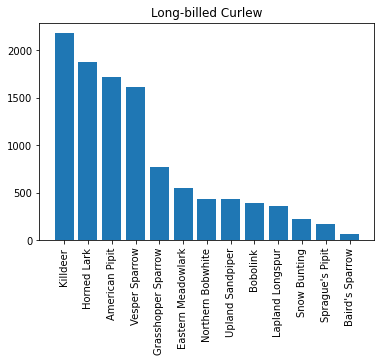

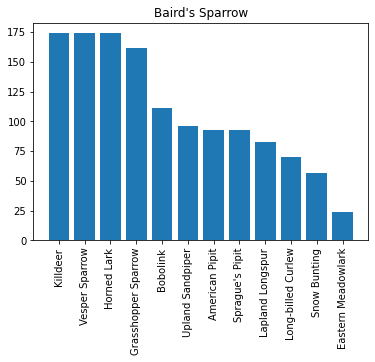

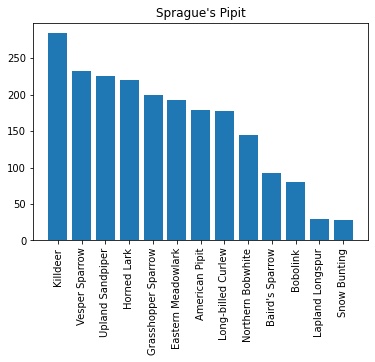

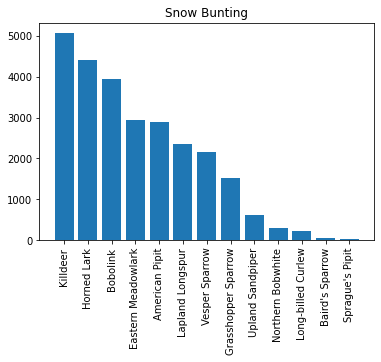

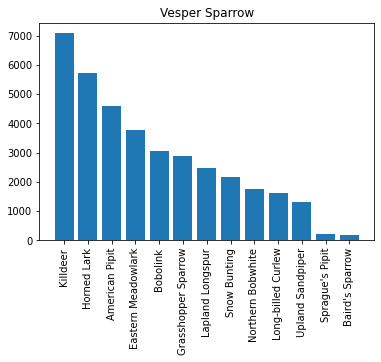

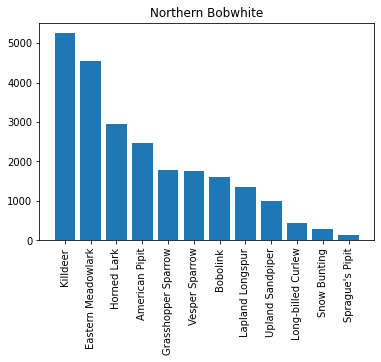

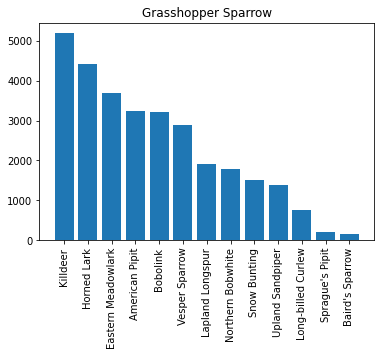

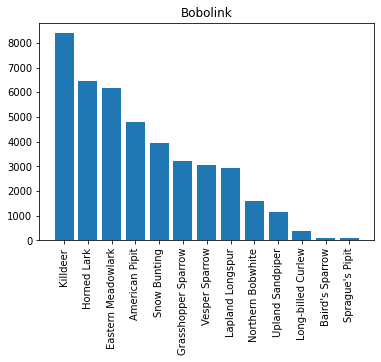

In [16]:
sum_obs_agg = obs_agg_full.groupby(['common_name', 'fips_code'], as_index=False)['observation_count'].sum()
fips = list(sum_obs_agg['fips_code'])
names = list(sum_obs_agg['common_name'])
counts = list(sum_obs_agg['observation_count'])

species_to_exclude = ['Red-winged Blackbird', 'Song Sparrow', 'House Sparrow']

def network_analysis(spec, threshold):

    species = list(obs_agg_full['common_name'].unique())
    species_pairs = combinations(species, 2)

    dd = defaultdict(dict)

    for i in range(len(names)):
        dd[names[i]][fips[i]] = counts[i]

    candidate_pairs = Counter()

    for pair in species_pairs:
        if spec in pair:
            for f in fips:

                species_one = pair[0]
                species_two = pair[1]
                
                if species_one not in species_to_exclude and species_two not in species_to_exclude:
                    try:
                        counts_one = dd[species_one][f]
                    except:
                        continue
                    try:
                        counts_two = dd[species_two][f]
                    except:
                        continue

                    if counts_one > threshold and counts_two > threshold:
                        candidate_pairs[pair] += 1
                    
    return candidate_pairs
            
viz_d = {}

def visualize_most_common(species):
        n = network_analysis(species, 25)
        common = n.most_common(20)
        
        viz_d = {}
        for k in common:
            spec = list(k[0])
            spec = sorted(spec, key=lambda x:(x!=species, x)) # ensuring main species always comes first
            other_species = spec[1]
            viz_d[other_species] = k[1]
            
            names = list(viz_d.keys())
            values = list(viz_d.values())
            
        plt.bar(range(len(names)), values, tick_label=names)
        plt.title(species)
        plt.xticks(rotation = 90)
        plt.show()

network_check = ['Long-billed Curlew', 'Baird\'s Sparrow', 'Sprague\'s Pipit', 'Snow Bunting',
                'Vesper Sparrow', 'Northern Bobwhite', 'Grasshopper Sparrow', 'Bobolink']

for species in network_check:
    visualize_most_common(species)

<h3>Question 4 Results: </h3>

The intent of this final analysis was to add some context to which species share common habitats and have populations in the same counties. An intrinsic limitation to this analysis was that some species occur much more frequently than others, such as Killdeer, thus Killdeer always was the strongest link with every species during the network analysis. Regardless, some interesting insights can be drawn from the analysis. Ultimately, the goal is to show the magnitude of shared geography a species has with all other species in the list. In this sense, conservation efforts could be targeted to counties with the largest number of species of highest conservation concern.

We can gain relevant information about its preferred habitat and the others species that most critically rely on similar habitat. While killdeer appears first on all visualizations because it is relatively ubiquitous, the following ranks seem to depend much more heavily on environment and habitat preference. 

Of the above network analyses, one interesting trend emerges:

Baird's sparrow is one of the rarest grassland bird species. Baird's sparrow has a strong relationship with Vesper Sparrow in terms of which counties it is sighted in most frequently. This is notable, because in the previous analysis (linear regression of agricultural practices vs observation counts), it was suggested that both species prefer pastureland in farms as habitat. Grasshopper sparrow followed shortly behind in the link relationship, which coincides with the prior correlation analysis. Notably, Sprague's Pipit and Upland Sandpiper also seem to have relatively strong shared geography with Baird's Sparrow, logically resonating with prior analysis showing that all three of these species prefer pastureland as habitat.

Ultimately, this analysis was limited in the fact that the species present were manually selected during data preparation. Includuing all species found in the lower 48 of the USA would lead to a much more interesting network analysis of species habitat, however the dataset construction would be incredibly unfeasible (petabytes of data, at least). Regardless, the network analysis above brings to light which species tend to associate in similar habitats.